In [1]:
import pandas as pd
import numpy as np


from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC

import matplotlib.pyplot as plt
import seaborn as sns

import re

In [37]:
gfm_data = pd.read_excel('GoFundMe.xlsx')

In [38]:
gfm_data.head()

,Url,Category,Position,Title,Location,Amount_Raised,Goal,Number_of_Donators,Length_of_Fundraising,FB_Shares,GFM_hearts,Text,Latitude,Longitude,FB_Shares_Format,GFM_hearts_Format
0,https://www.gofundme.com/3ctqm-medical-bills-f...,Medical,0.0,92 Yr old Man Brutally Attacked.,"LOS ANGELES, CA",327345.0,15000.0,12167,30.0,26k,12k,Rodolfo Rodriguez needs your help today! 92 Yr...,34.052234,-118.243685,26000,12000
1,https://www.gofundme.com/olivia-stoy-bone-marr...,Medical,0.0,Olivia Stoy:Transplant & Liv it up!,"ASHLEY, IN",316261.0,1000000.0,5598,90.0,12k,5.7k,Thomas Stoy needs your help today! Olivia Stoy...,41.527273,-85.065523,12000,5700
2,https://www.gofundme.com/autologous-Tcell-Tran...,Medical,1.0,AUTOLOGOUS T CELL TRANSPLANT,"STATEN ISLAND, NY",241125.0,250000.0,841,60.0,1.8k,836,Philip Defonte needs your help today! AUTOLOGO...,40.579532,-74.150201,1800,836
3,https://www.gofundme.com/a-chance-of-rebirth,Medical,1.0,A chance of rebirth,"DUBLIN, CA",237424.0,225000.0,4708,30.0,9.7k,4.7k,Sriram Kanniah needs your help today! A chance...,37.702152,-121.935792,9700,4700
4,https://www.gofundme.com/teamclaire,Medical,1.0,Claire Wineland Needs Our Help,"GARDEN GROVE, CA",236590.0,225000.0,8393,60.0,6.4k,8.9k,Melissa Yeager needs your help today! Claire W...,33.774269,-117.937995,6400,8900


In [39]:
# gfm_data.Position.value_counts()

In [40]:
# gfm_data.Length_of_Fundraising.value_counts()

In [41]:
# a['Name'] = np.where(df['Set']=='Z', 'green', 'red')
# x =gfm_data['Length_of_Fundraising'].str.replace('\a+', '')
# x

In [42]:
gfm_data['GoalAchieved'] = np.where(gfm_data['Amount_Raised'] >= gfm_data['Goal'], 'Yes','No')
# gfm_data['GoalAchieved'] = gfm_data['GoalAchieved'].astype('bool')

### Let's get an idea of the number of campaigns that met their goal or didn't

In [43]:
goalAchieved = pd.DataFrame((gfm_data['GoalAchieved']).value_counts())
goalAchieved

,GoalAchieved
No,786
Yes,456


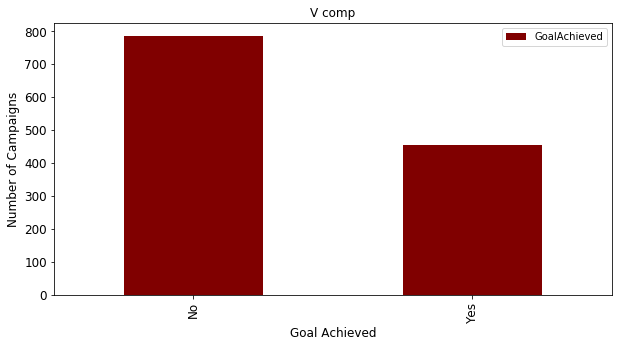

In [44]:
ax = goalAchieved[['GoalAchieved']].plot(kind='bar', title ="V comp", figsize=(10, 5), legend=True, fontsize=12, color='maroon')
ax.set_xlabel("Goal Achieved", fontsize=12)
ax.set_ylabel("Number of Campaigns", fontsize=12)
plt.show()

### Thus, we see that we have 456 successful campaigns, and 786 unsuccessful campaigns in our data

## Plotting the Correlations in the data frame

Code from: https://seaborn.pydata.org/examples/many_pairwise_correlations.html

In [45]:
corr = gfm_data.corr()
corr

,Position,Amount_Raised,Goal,Length_of_Fundraising,Latitude,Longitude,FB_Shares_Format,GFM_hearts_Format
Position,1.000000,-0.013714,-0.012950,0.051280,-0.022002,-0.036323,-0.012284,-0.011308
Amount_Raised,-0.013714,1.000000,0.634603,-0.044092,-0.059306,0.017689,0.729750,0.905153
Goal,-0.012950,0.634603,1.000000,0.001579,-0.068443,-0.028549,0.462030,0.537796
Length_of_Fundraising,0.051280,-0.044092,0.001579,1.000000,-0.033316,0.024910,-0.078651,-0.039694
Latitude,-0.022002,-0.059306,-0.068443,-0.033316,1.000000,0.173531,-0.029403,-0.031933
Longitude,-0.036323,0.017689,-0.028549,0.024910,0.173531,1.000000,0.025169,0.019724
FB_Shares_Format,-0.012284,0.729750,0.462030,-0.078651,-0.029403,0.025169,1.000000,0.756389
GFM_hearts_Format,-0.011308,0.905153,0.537796,-0.039694,-0.031933,0.019724,0.756389,1.000000


In [46]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

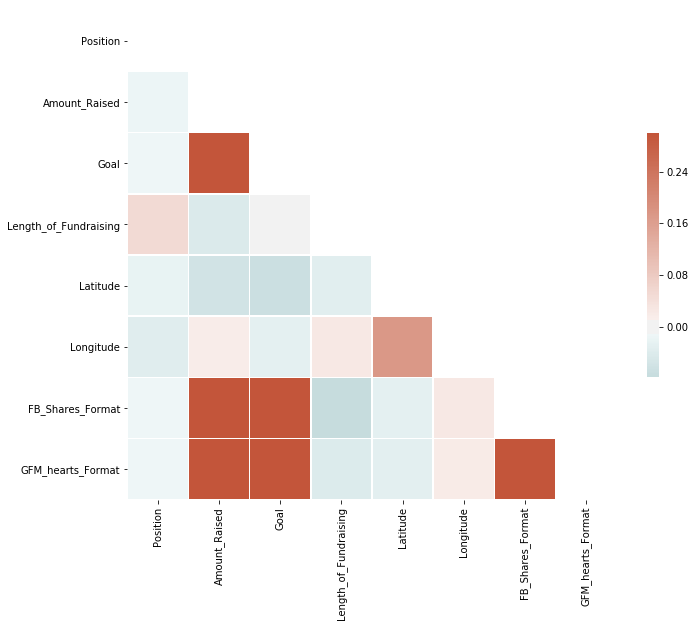

In [47]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(200, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Running an ML pipeline

In [48]:
gfm_data = gfm_data.dropna()
gfm_data.head()

,Url,Category,Position,Title,Location,Amount_Raised,Goal,Number_of_Donators,Length_of_Fundraising,FB_Shares,GFM_hearts,Text,Latitude,Longitude,FB_Shares_Format,GFM_hearts_Format,GoalAchieved
0,https://www.gofundme.com/3ctqm-medical-bills-f...,Medical,0.0,92 Yr old Man Brutally Attacked.,"LOS ANGELES, CA",327345.0,15000.0,12167,30.0,26k,12k,Rodolfo Rodriguez needs your help today! 92 Yr...,34.052234,-118.243685,26000,12000,Yes
1,https://www.gofundme.com/olivia-stoy-bone-marr...,Medical,0.0,Olivia Stoy:Transplant & Liv it up!,"ASHLEY, IN",316261.0,1000000.0,5598,90.0,12k,5.7k,Thomas Stoy needs your help today! Olivia Stoy...,41.527273,-85.065523,12000,5700,No
2,https://www.gofundme.com/autologous-Tcell-Tran...,Medical,1.0,AUTOLOGOUS T CELL TRANSPLANT,"STATEN ISLAND, NY",241125.0,250000.0,841,60.0,1.8k,836,Philip Defonte needs your help today! AUTOLOGO...,40.579532,-74.150201,1800,836,No
3,https://www.gofundme.com/a-chance-of-rebirth,Medical,1.0,A chance of rebirth,"DUBLIN, CA",237424.0,225000.0,4708,30.0,9.7k,4.7k,Sriram Kanniah needs your help today! A chance...,37.702152,-121.935792,9700,4700,Yes
4,https://www.gofundme.com/teamclaire,Medical,1.0,Claire Wineland Needs Our Help,"GARDEN GROVE, CA",236590.0,225000.0,8393,60.0,6.4k,8.9k,Melissa Yeager needs your help today! Claire W...,33.774269,-117.937995,6400,8900,Yes


In [49]:
# Train-test split, using type variable as target and posts variable as predictor
X_train, X_test, y_train, y_test = train_test_split(gfm_data[['FB_Shares_Format', 'GFM_hearts_Format', 'Length_of_Fundraising']].values,
                                                   gfm_data['GoalAchieved'].values,
                                                   test_size=0.30, random_state=42)
print('X_train ', X_train.shape, '\n', 'X_test ', X_test.shape, '\n', 'y_train ', y_train.shape, '\n', 
      'y_test', y_test.shape)


X_train  (829, 3) 
 X_test  (356, 3) 
 y_train  (829,) 
 y_test (356,)


### Thus, we see that we have 869 rows in our training data, and 373 rows in our test set

## Linear Regression

In [69]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)


C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [72]:
logisticRegr.predict(X_test)
predictions = logisticRegr.predict(X_test)


In [73]:
# Use score method to get accuracy of model
score = logisticRegr.score(X_test, y_test)
print(score)

0.6685393258426966


[[237   1]
 [117   1]]


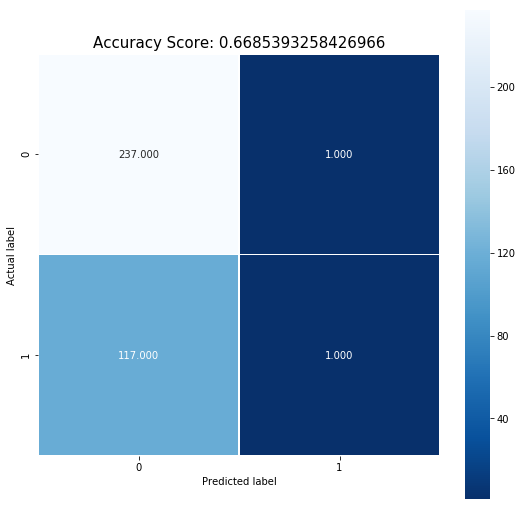

In [75]:
cm = metrics.confusion_matrix(y_test, predictions)
print(cm)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

### Model: Random Forest Classifier
RandomForestClassifier is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting.

In [50]:
rfc = RandomForestClassifier(n_estimators=30)
#                              , min_samples_leaf=50, oob_score=True, n_jobs= -1, random_state=123)
rfc.fit(X_train, y_train)
print("TRAINING SET")
print("Accuracy: ", rfc.score(X_train, y_train))
print("Confusion Matrix:")
print(confusion_matrix(y_train, rfc.predict(X_train)))
print("Classification Report:")
print(classification_report(y_train, rfc.predict(X_train)))
print("")

TRAINING SET
Accuracy:  0.9987937273823885
Confusion Matrix:
[[512   0]
 [  1 316]]
Classification Report:
              precision    recall  f1-score   support

          No       1.00      1.00      1.00       512
         Yes       1.00      1.00      1.00       317

   micro avg       1.00      1.00      1.00       829
   macro avg       1.00      1.00      1.00       829
weighted avg       1.00      1.00      1.00       829




In [51]:
print("TEST SET")
print("Accuracy: ", rfc.score(X_test, y_test))
print("Confusion Matrix:")
print(confusion_matrix(y_test, rfc.predict(X_test)))
print("Classification Report:")
print(classification_report(y_test, rfc.predict(X_test)))

TEST SET
Accuracy:  0.5674157303370787
Confusion Matrix:
[[165  73]
 [ 81  37]]
Classification Report:
              precision    recall  f1-score   support

          No       0.67      0.69      0.68       238
         Yes       0.34      0.31      0.32       118

   micro avg       0.57      0.57      0.57       356
   macro avg       0.50      0.50      0.50       356
weighted avg       0.56      0.57      0.56       356



### Thus, we see that the Random Forest Classifier overfits the training data. So while we have an accuracy of 99% for the training data, the accuracy on test data is only 56%. We can resolve this by using cross validation in our ML pipeline

In [52]:
# Define the Parameter Grid

param_grid = {
                 'n_estimators': [5, 10, 20, 50],
                 'max_depth': [2, 5, 7, 9]
             }

In [53]:
# Define the GridSearchCV for the Random Forest Classifer
grid_rfc = GridSearchCV(rfc, param_grid, cv=10)
grid_rfc.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [5, 10, 20, 50], 'max_depth': [2, 5, 7, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [54]:
print('##########   Best Classfier:    ############') 
grid_rfc. best_estimator_

grid_rfc. best_params_



##########   Best Classfier:    ############


{'max_depth': 5, 'n_estimators': 20}

In [55]:
grid_rfc.best_score_

0.6248492159227985

## Thus, we see that there is a slight improvement of the accuracy to 63% by using cross validation

In [56]:
# Convert the confusion Matric to a dataframe to display a heatmap
knn_confMat = np.array(confusion_matrix(y_test, grid_rfc.predict(X_test)))
confMat_knn = pd.DataFrame(knn_confMat, index=['Actual Yes', 'Actual No'],
                          columns=['Predicted Yes', 'Predicted No'])

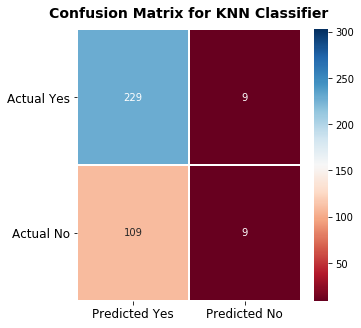

In [57]:
# Plot the confusion matrix as a heatmap
import seaborn as sns
fig, ax = plt.subplots(figsize=(5,5))
plt.title('Confusion Matrix for KNN Classifier', fontweight = 'bold',
         y = 1.02, fontsize=14)

sns.heatmap(confMat_knn, robust=True, annot=True, linewidth=0.5, 
            fmt='', cmap='RdBu', vmax=303, ax=ax)
plt.xticks(fontsize=12)
plt.yticks(rotation=0, fontsize=12);

## Model : KNeighbors Classifier Model

KNeighborsClassifier is a nonparametric classification model that finds the observations in its training data that are "nearest" to the observation to predict; it then averages or takes a vote of those training observations' target values to estimate the value for the new data point.

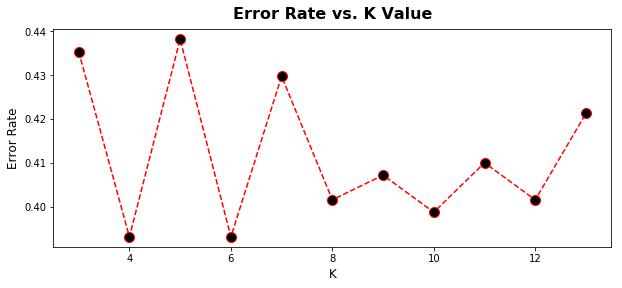

In [58]:
# Run the kNN classifier and find the optimal number of neighbors to use

error_rate = []

for i in range(3,14):
    knn_lc = KNeighborsClassifier(n_neighbors=i)
    knn_lc.fit(X_train, y_train)
    
    pred_i = knn_lc.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))
    
plt.figure(figsize=(10, 4))
plt.plot(range(3,14), error_rate, color='red', linestyle='dashed',
         marker='o', markerfacecolor='black', markersize=10)
plt.title('Error Rate vs. K Value', fontsize=16,
          fontweight='bold', y=1.02)
plt.xlabel('K', fontsize=12, y=1.02)
plt.ylabel('Error Rate', fontsize=12, x=1.02);

### Thus, we find that the error rate is lowest for 6 neighbors. 

### Let us recheck this fact by running a GridSearch on the classifier as well

In [60]:
# Grid Search to find the best parameters on KNeighbors Classifier
knn_param_dict = {
    'n_neighbors': [4, 6, 7, 8, 9,10,13],
    'weights': ['uniform', 'distance'],
    'p': [1,2],}
        # p = power parameter for the Minkowski metric. 
        # 1 is Manhattan; 2 is Euclidean

In [61]:

knn = KNeighborsClassifier()
gs_knn = GridSearchCV(knn, knn_param_dict, verbose=2, n_jobs=-1, scoring="accuracy")
# if n_jobs = -1, then the number of jobs is set to the number of CPU cores.
gs_knn.fit(X_train, y_train)

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:    2.4s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_neighbors': [4, 6, 7, 8, 9, 10, 13], 'weights': ['uniform', 'distance'], 'p': [1, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=2)

In [62]:

print('Best score: ', gs_knn.best_score_)
print('Best parameters: ', gs_knn.best_params_)

Best score:  0.6103739445114595
Best parameters:  {'n_neighbors': 8, 'p': 2, 'weights': 'uniform'}


The grid search suggests that the optimal number of neighbors is 8. The optimal weight function is 'uniform,' where points are all assigned weights uniformly. These hyperparameters will be used in the KNeighborsClassifier model. The optimal power parameter (p) for the Minkowski metric is 1, indicating Manhattan distance. This is the default parameter for this model so no adjustments are needed on that hyperparameter.

In [63]:
# Fit and score a KNeighborsClassifier using 13 neighbors and distance weighting function
knn = KNeighborsClassifier(n_neighbors=8, weights='uniform')
knn.fit(X_train, y_train)
print("TRAINING SET")
print("Accuracy: ", knn.score(X_train, y_train))
print("Confusion Matrix:")
print(confusion_matrix(y_train, knn.predict(X_train)))
print("Classification Report:")
print(classification_report(y_train, knn.predict(X_train)))
print("")


TRAINING SET
Accuracy:  0.6586248492159228
Confusion Matrix:
[[460  52]
 [231  86]]
Classification Report:
              precision    recall  f1-score   support

          No       0.67      0.90      0.76       512
         Yes       0.62      0.27      0.38       317

   micro avg       0.66      0.66      0.66       829
   macro avg       0.64      0.58      0.57       829
weighted avg       0.65      0.66      0.62       829




In [64]:

print("TEST SET")
print("Accuracy: ", knn.score(X_test, y_test))
print("Confusion Matrix:")
print(confusion_matrix(y_test, knn.predict(X_test)))
print("Classification Report:")
print(classification_report(y_test, knn.predict(X_test)))

TEST SET
Accuracy:  0.598314606741573
Confusion Matrix:
[[189  49]
 [ 94  24]]
Classification Report:
              precision    recall  f1-score   support

          No       0.67      0.79      0.73       238
         Yes       0.33      0.20      0.25       118

   micro avg       0.60      0.60      0.60       356
   macro avg       0.50      0.50      0.49       356
weighted avg       0.56      0.60      0.57       356



In [65]:
# Convert the confusion Matric to a dataframe to display a heatmap
knn_confMat = np.array(confusion_matrix(y_test, knn.predict(X_test)))
confMat_knn = pd.DataFrame(knn_confMat, index=['Actual Yes', 'Actual No'],
                          columns=['Predicted Yes', 'Predicted No'])

In [66]:
confMat_knn

,Predicted Yes,Predicted No
Actual Yes,189,49
Actual No,94,24


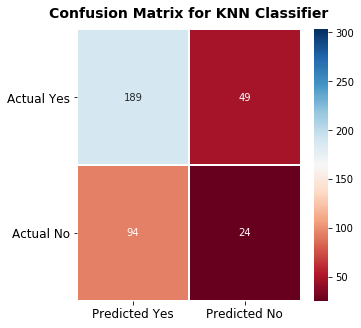

In [67]:
# Plot the confusion matrix as a heatmap
import seaborn as sns
fig, ax = plt.subplots(figsize=(5,5))
plt.title('Confusion Matrix for KNN Classifier', fontweight = 'bold',
         y = 1.02, fontsize=14)

sns.heatmap(confMat_knn, robust=True, annot=True, linewidth=0.5, 
            fmt='', cmap='RdBu', vmax=303, ax=ax)
plt.xticks(fontsize=12)
plt.yticks(rotation=0, fontsize=12);